In [1]:
import cobra
import matplotlib.pyplot as plt
import pandas as pd
import json

from sklearn.decomposition import PCA

from amg_utils import amg_limits
from plotting_utils import plot_impact_graph

In [2]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")
amgs = json.loads(open("model_files/amg_reactions.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())

In [3]:
with model as healthy:
    fva_healthy = cobra.flux_analysis.flux_variability_analysis(healthy)
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg = cobra.flux_analysis.flux_variability_analysis(phm2)
print(fva_healthy[fva_healthy.index == "BIOMASS"])
print(fva_healthy[fva_healthy.index == "PHM2_prodrxn_VN"])
print("-" * 80)
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "BIOMASS"])
print(fva_phm2_no_amg[fva_phm2_no_amg.index == "PHM2_prodrxn_VN"])

          minimum   maximum
BIOMASS  0.098462  0.098462
                 minimum       maximum
PHM2_prodrxn_VN      0.0  1.418384e-12
--------------------------------------------------------------------------------
         minimum       maximum
BIOMASS      0.0 -3.601452e-13
                  minimum   maximum
PHM2_prodrxn_VN  0.183896  0.183896


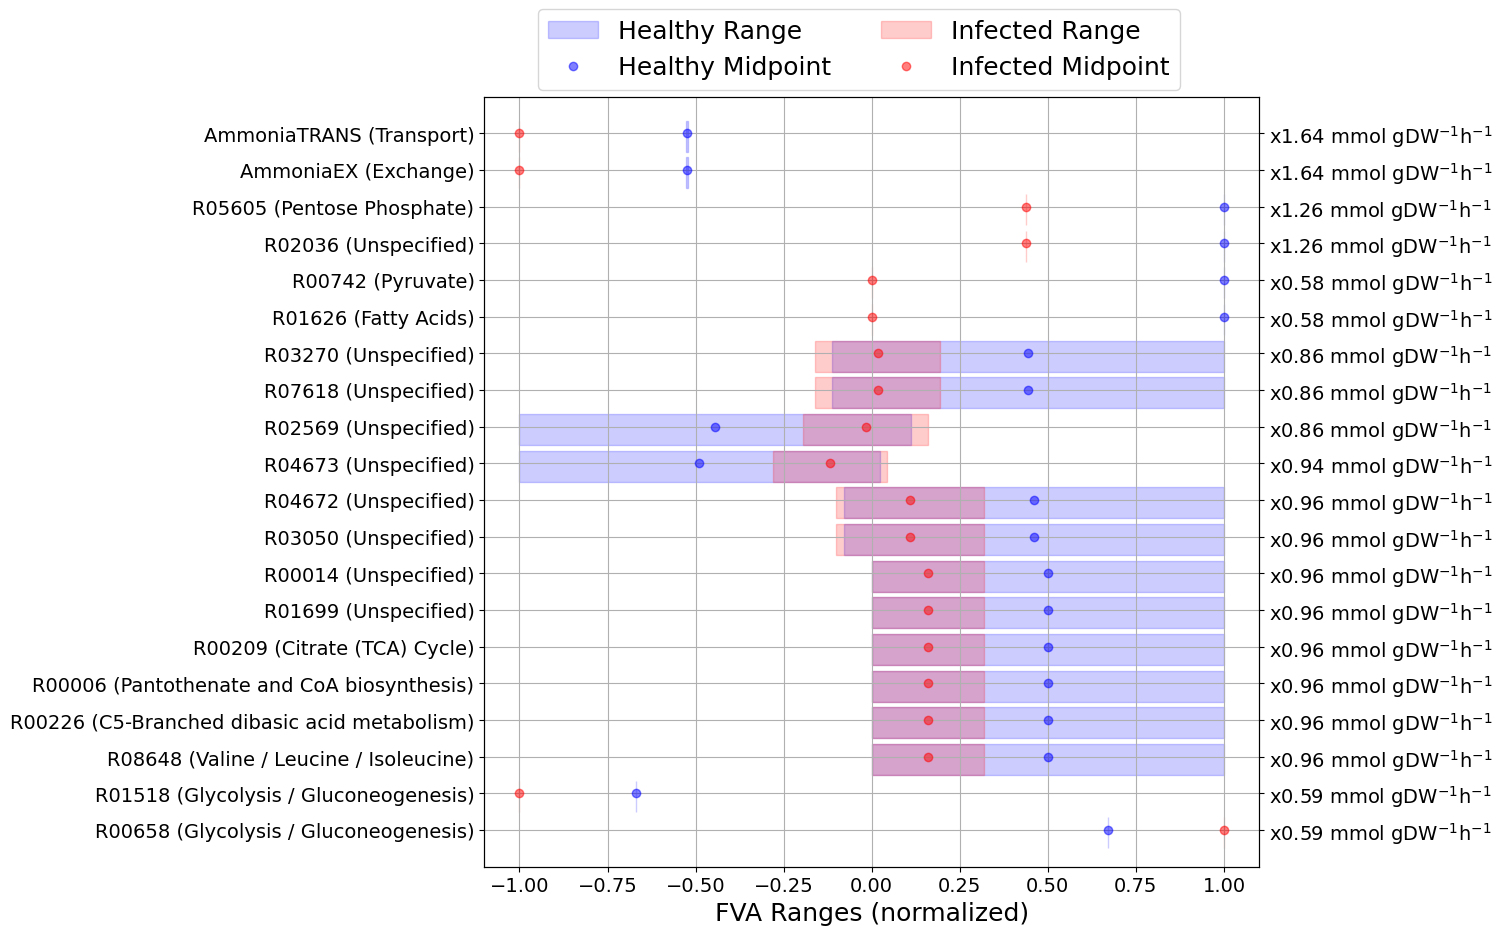

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_impact_graph(
    ax, model, fva_healthy, fva_phm2_no_amg, amgs, manual_relabels, cut=0.2
)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
fig.legend(
    [
        "Healthy Range",
        "Healthy Midpoint",
        "Infected Range",
        "Infected Midpoint",
    ],
    ncols=2,
    loc="upper center",
    fontsize=18,
    bbox_to_anchor=(0.5, 0.98),
)
plt.show()

In [5]:
with model as healthy:
    fva_healthy_amg = cobra.flux_analysis.flux_variability_analysis(
        healthy, list(amgs.keys())
    )
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
    fva_phm2_no_amg_amg = cobra.flux_analysis.flux_variability_analysis(
        phm2, list(amgs.keys())
    )

In [6]:
# For some ridiculous reason, this is both faster and more numerically
# consistent that using the built-in reaction list feature...
h1 = {}
h2 = {}
i1 = {}
i2 = {}
for amg in amgs:
    with model as healthy:
        res = cobra.flux_analysis.flux_variability_analysis(
            healthy,
            [amg],
            fraction_of_optimum=0.5,
        )

    h1[amg] = res["minimum"][amg]
    h2[amg] = res["maximum"][amg]

    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        res = cobra.flux_analysis.flux_variability_analysis(
            phm2,
            [amg],
            fraction_of_optimum=0.5,
        )
    i1[amg] = res["minimum"][amg]
    i2[amg] = res["maximum"][amg]
fva_healthy_amg2 = pd.DataFrame({"minimum": h1, "maximum": h2})
fva_phm2_amg2 = pd.DataFrame({"minimum": i1, "maximum": i2})

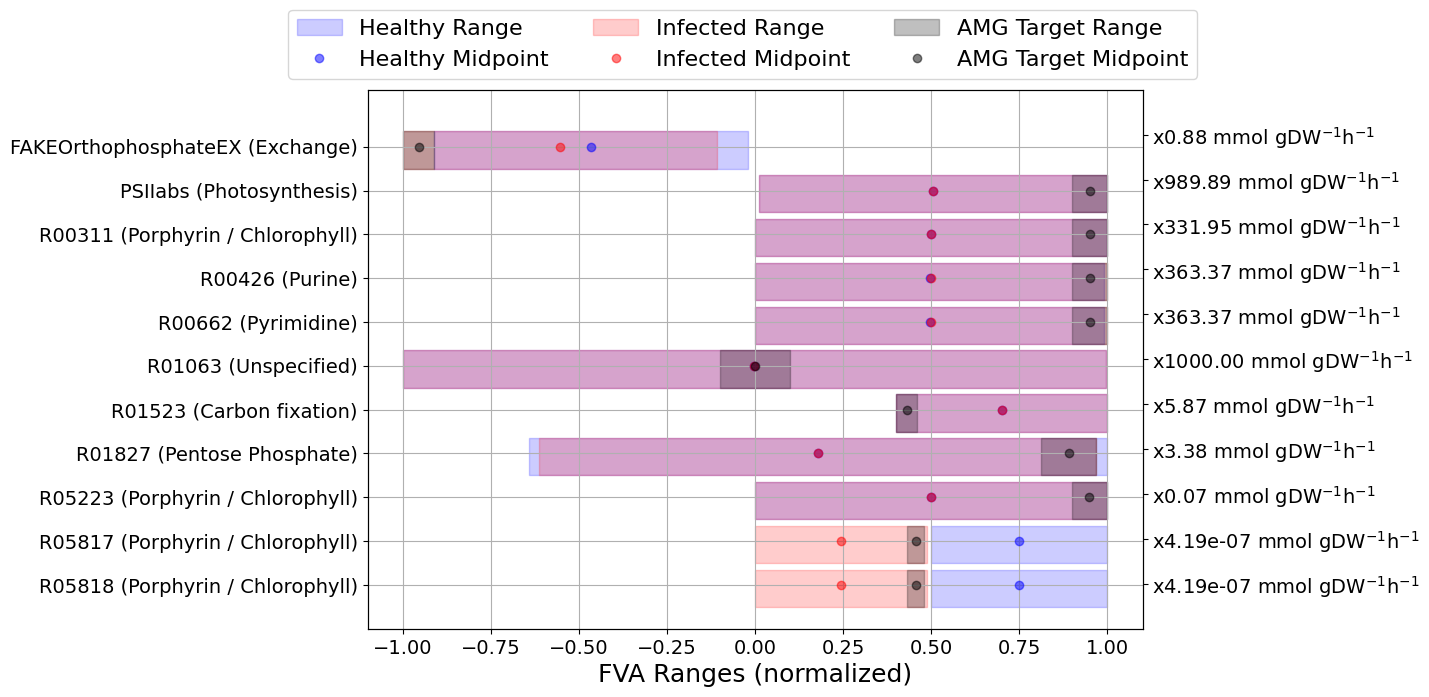

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
highlights = {}
for i, (amg, direction) in enumerate(amgs.items()):
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    highlights[amg] = (lb, ub)

plot_impact_graph(
    ax,
    model,
    fva_healthy_amg2,
    fva_phm2_amg2,
    [],
    manual_relabels,
    cut=0,
    sort=False,
    highlights=highlights,
)
ax.set_ylim(-11, 1.3)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
fig.axes[1].tick_params(labelsize=14)
# ax.set_title("Biomass Lax Optimization Impact on AMG-Hijacked Reactions", fontsize=22)
fig.legend(
    [
        "Healthy Range",
        "Healthy Midpoint",
        "Infected Range",
        "Infected Midpoint",
        "AMG Target Range",
        "AMG Target Midpoint",
    ],
    ncols=3,
    loc="upper center",
    fontsize=16,
    bbox_to_anchor=(0.5, 1.01),
)
plt.show()

In [48]:
amg_new_vals = {}
for amg, direction in amgs.items():
    with model as phm2:
        phm2.objective = phm2.reactions.PHM2_prodrxn_VN.flux_expression
        lb, ub = amg_limits(phm2, amg, direction, optimum_fraction=0.5, tol=0.1)
    amg_new_vals[amg] = (lb + ub) / 2
amg_new_vals

{'FAKEOrthophosphateEX': np.float64(-0.8378580935670241),
 'PSIIabs': np.float64(940.8959434104111),
 'R00311': np.float64(315.35381478701333),
 'R00426': np.float64(345.2020865248845),
 'R00662': np.float64(345.20208652488446),
 'R01063': np.float64(0.0),
 'R01523': np.float64(2.5262500000001102),
 'R01827': np.float64(3.012405245444948),
 'R05223': np.float64(0.07087301587301495),
 'R05817': np.float64(1.9110132487691267e-07),
 'R05818': np.float64(1.911013248769127e-07)}

In [49]:
amg_fvas = {}
for amg, new_val in amg_new_vals.items():
    with model as phm2:
        phm2.reactions.get_by_id(amg).bounds = new_val, new_val
        fva_phm2 = cobra.flux_analysis.flux_variability_analysis(phm2)
    amg_fvas[amg] = fva_phm2.copy()


In [50]:
hmid = (fva_healthy["maximum"] + fva_healthy["minimum"]) / 2
mdiffs = {}
for amg, fva in sorted(amg_fvas.items()):
    mids = (fva["maximum"] + fva["minimum"]) / 2
    mid_diff = mids - hmid
    mdiffs[amg] = mid_diff
mdf = pd.DataFrame(mdiffs)

In [69]:
mdf_filtered = mdf[mdf.abs().max(axis=1) >= 0.25].apply(lambda x: x)
mdf_filtered["Phage Biomass"] = (
    fva_phm2_no_amg["maximum"] + fva_phm2_no_amg["minimum"]
) / 2 - hmid

mdf_filtered = mdf_filtered.sort_index(
    axis=0,
    key=lambda x: [model.reactions.get_by_id(y).subsystem for y in x],
)
last = ""
switch_inds = [(0, "Unspecified")]
for i, (rxn, row) in enumerate(mdf_filtered.iterrows()):
    ss = model.reactions.get_by_id(rxn).subsystem
    if last != ss:
        last = ss
        if ss in manual_relabels:
            ss = manual_relabels[ss]
        switch_inds.append((i, ss))

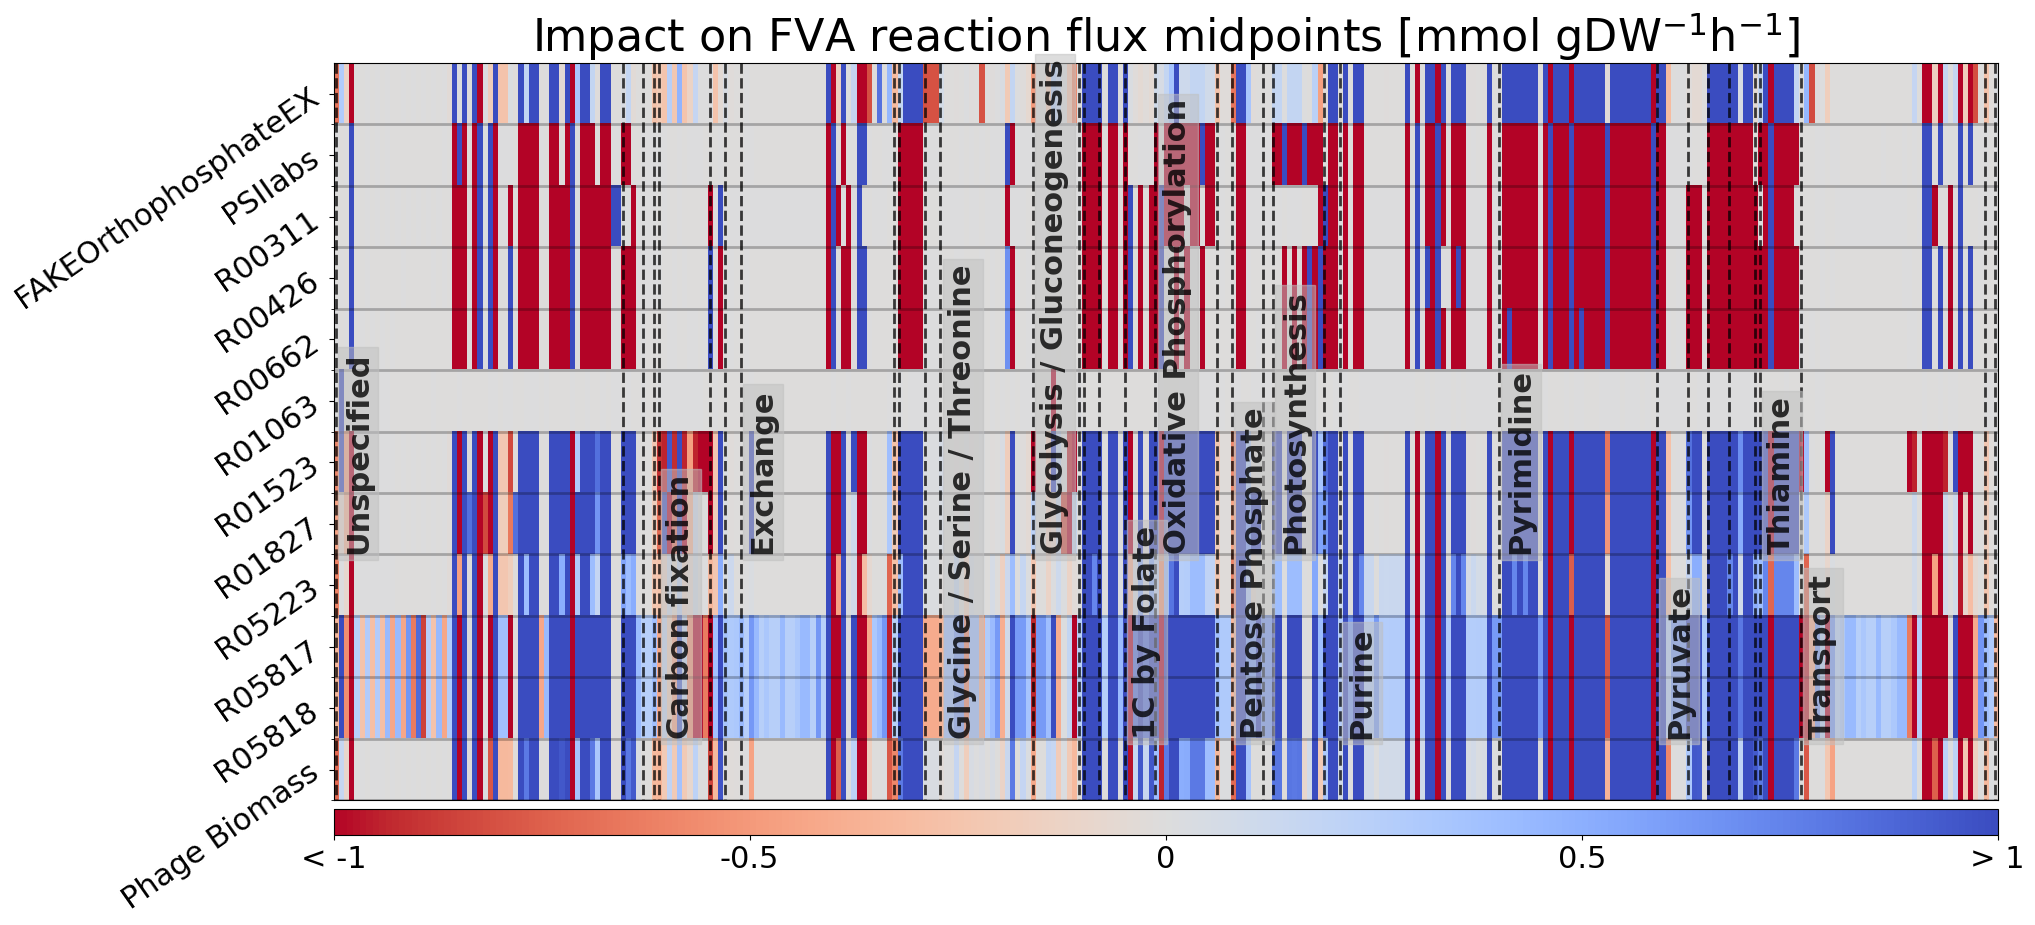

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = ax.matshow(
    mdf_filtered.T,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1,
    aspect=12,
    interpolation="none",
)
ticks = range(1 + len(sorted(amgs.keys())))

ax.set_yticks(ticks, minor=False)
ax.set_yticks([0.5 + x for x in ticks], minor=True)
ax.set_yticklabels(sorted(amgs.keys()) + ["Phage Biomass"], fontsize=22, rotation=35)
ax.set_xticks([])
ax.grid(True, which="minor", alpha=0.25, color="black", linewidth=2)
ax.set_title(
    "Impact on FVA reaction flux midpoints " + r"[mmol gDW$^{-1}$h$^{-1}$]", fontsize=32
)
cbar = fig.colorbar(
    im,
    aspect=64,
    orientation="horizontal",
    pad=0.01,
)
cbar.set_ticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=["< -1", "-0.5", "0", "0.5", "> 1"],
    fontsize=22,
)

offset = -1.5
for line, (i, ss) in enumerate(switch_inds):
    if ss == "":
        ss = "Unspecified"
    ax.vlines(
        i, -0.5, 11.5, linestyles="dashed", color="black", alpha=0.75, linewidth=2
    )
    if (line < len(switch_inds) - 1) and switch_inds[line + 1][0] - i > 5:
        ax.text(
            i + 1.5,
            9.0 + offset,
            ss,
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=22,
            fontweight="bold",
            rotation=90,
            color="black",
            alpha=0.8,
            backgroundcolor="#c0c0c088",
        )
        offset *= -1


fig.tight_layout()
# fig.savefig("phage_barcode.png")
plt.show()

In [ ]:
pcadf = pd.concat([mdf.iloc[:, 0] * 0, mdf], axis=1)
pcadf.columns = ["No AMG"] + list(mdf.columns)
pcadf
df_normalized = ((pcadf - pcadf.mean()) / pcadf.std()).fillna(0)

pca = PCA(n_components=pcadf.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC%s" % _ for _ in range(len(df_normalized.columns))],
    index=pcadf.columns,
)
loadings

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
No AMG,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,1.0,-0.000000e+00
FAKEOrthophosphateEX,3.291636e-01,2.002800e-12,1.222723e-01,3.368826e-02,2.826114e-01,3.295539e-01,-6.522937e-01,7.465772e-02,-5.046827e-01,-3.640684e-02,0.0,-4.930843e-13
PSIIabs,-3.140987e-01,-1.247793e-11,-1.486224e-01,-6.095562e-01,5.235884e-01,4.202568e-01,2.339417e-01,-4.115269e-02,-2.201148e-02,-5.222603e-03,0.0,9.675627e-13
R00311,-1.827414e-01,-2.772948e-12,9.734469e-01,-1.184107e-01,9.165233e-03,-9.964774e-03,6.481387e-02,3.592227e-03,2.422782e-02,-1.259831e-03,0.0,1.933720e-13
R00426,-3.226858e-01,3.043481e-12,-4.335470e-03,4.191346e-01,-3.675129e-01,7.518427e-01,1.108269e-01,-6.826734e-02,-5.033686e-02,-1.926860e-02,0.0,-6.561111e-13
R00662,-3.146603e-01,4.172784e-12,6.110844e-03,6.435543e-01,6.719717e-01,-1.735561e-01,6.932428e-02,1.064614e-02,1.393719e-02,2.874044e-03,0.0,1.379975e-12
R01063,-6.571360e-12,1.000000e+00,-4.084325e-14,-1.274925e-11,3.360065e-12,2.268024e-12,4.891561e-13,3.502754e-12,2.060829e-12,1.240940e-13,0.0,-1.859740e-14
R01523,3.339797e-01,3.549865e-12,6.288438e-02,6.737864e-02,1.133094e-01,1.301156e-01,1.265873e-01,-4.386438e-01,1.001390e-01,7.948167e-01,0.0,1.467447e-12
R01827,3.322037e-01,2.759889e-12,4.088420e-02,8.231865e-02,1.447861e-02,1.703760e-03,6.614277e-01,3.580420e-01,-5.614108e-01,1.083854e-02,0.0,-1.038483e-13
R05223,3.327599e-01,-1.623243e-12,5.518831e-02,6.336403e-02,1.457111e-01,2.813549e-01,-1.361485e-02,6.391975e-01,6.076328e-01,6.197870e-02,0.0,6.831802e-13


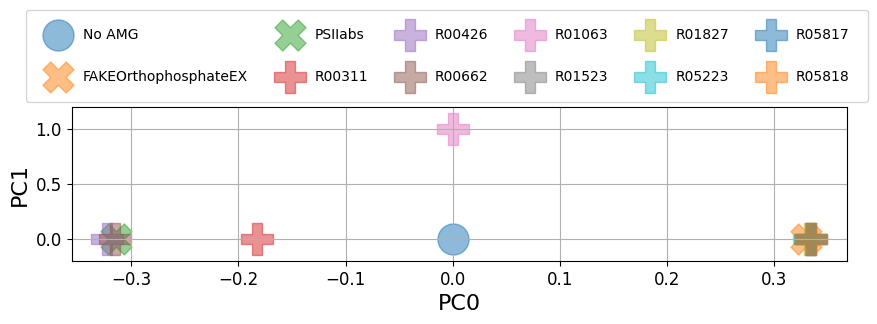

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
for i, row in loadings.iterrows():
    x = row["PC0"]
    y = row["PC1"]
    ax.scatter(
        x,
        y,
        label=i,
        marker="P" if i.startswith("R") else "o" if i == "No AMG" else "X",
        s=500,
        alpha=0.5,
    )
ax.grid(True)
ax.tick_params(axis="both", which="both", labelsize=12)
ax.set_xlabel("PC0", fontsize=16)
ax.set_ylabel("PC1", fontsize=16)
fig.legend(
    ncols=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.4),
    fontsize=10,
    labelspacing=2,
    borderpad=1.3,
)

ax.set_ylim([-0.2, 1.2])
plt.show()